# 3803ICT Big Data Analysis Assignment 

### Tyler Waugh and Long Nguyen

In [2]:
from __future__ import print_function
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

sns.set()
sns.set_style('whitegrid')

## 1) Data Preparation and Preprocessing

#### What steps were used for data preparation and preprocessing?
The data was imported using the pandas read_csv function for preprocessing and cleaning.  Most of the columns were already in an appropriate data format, with only the date of the job postings requiring conversion.
The ID column was removed as it doesn't have any meaningful purpose, being only the ID number for the job advertisement.

In [3]:
# Read in data
df = pd.read_csv('./data.csv')

# Check data types
df.dtypes

C:\Dev_Tools\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Id                   object
Title                object
Company              object
Date                 object
Location             object
Area                 object
Classification       object
SubClassification    object
Requirement          object
FullDescription      object
LowestSalary          int64
HighestSalary         int64
JobType              object
dtype: object

In [4]:
df.head()

,Id,Title,Company,Date,Location,Area,Classification,SubClassification,Requirement,FullDescription,LowestSalary,HighestSalary,JobType
0,37404348,Casual Stock Replenisher,Aldi Stores,2018-10-07T00:00:00.000Z,Sydney,North West & Hills District,Retail & Consumer Products,Retail Assistants,Our Casual Stock Replenishers pride themselves...,NaN,0,30,NaN
1,37404337,Casual Stock Replenisher,Aldi Stores,2018-10-07T00:00:00.000Z,Richmond & Hawkesbury,NaN,Retail & Consumer Products,Retail Assistants,Our Casual Stock Replenishers pride themselves...,NaN,0,30,NaN
2,37404356,RETAIL SALES SUPERSTARS and STYLISTS Wanted - ...,LB Creative Pty Ltd,2018-10-07T00:00:00.000Z,Brisbane,CBD & Inner Suburbs,Retail & Consumer Products,Retail Assistants,BRAND NEW FLAGSHIP STORE OPENING - SUNSHINE PLAZA,NaN,0,30,NaN
3,37404330,Team member - Belrose,Anaconda Group Pty Ltd,2018-10-07T00:00:00.000Z,Gosford & Central Coast,NaN,Retail & Consumer Products,Retail Assistants,Bring it on - do you love the great outdoors a...,NaN,0,30,NaN
4,37404308,"Business Banking Contact Centre Specialist, Ni...",Commonwealth Bank - Business & Private Banking,2018-10-07T00:00:00.000Z,Sydney,Ryde & Macquarie Park,Call Centre & Customer Service,Sales - Inbound,"We are seeking highly articulate, enthusiastic...",NaN,0,30,NaN


#### Clean Data

In [5]:
# Check for missing values in columns and print results
print('Missing Values (Counts):\nTitle: ', df[df['Title'].isna()].shape[0],
      '\nCompany: ', df[df['Company'].isna()].shape[0],
      '\nDate: ', df[df['Date'].isna()].shape[0],
      '\nLocation: ', df[df['Location'].isna()].shape[0],
      '\nArea: ', df[df['Area'].isna()].shape[0],
      '\nClassification: ', df[df['Classification'].isna()].shape[0],
      '\nSubClassification: ', df[df['SubClassification'].isna()].shape[0],
      '\nRequirement: ', df[df['Requirement'].isna()].shape[0],
      '\nFullDescription: ', df[df['FullDescription'].isna()].shape[0],
      '\nLowestSalary: ', df[df['LowestSalary'].isna()].shape[0],
      '\nHighestSalary: ', df[df['HighestSalary'].isna()].shape[0],
      '\nJobType: ', df[df['JobType'].isna()].shape[0], sep='')

# Convert Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)

# Show converted types
print('\n\nConverted Types:')
df.dtypes

Missing Values (Counts):
Title: 0
Company: 12004
Date: 0
Location: 121248
Area: 195819
Classification: 121248
SubClassification: 121248
Requirement: 7
FullDescription: 16175
LowestSalary: 0
HighestSalary: 0
JobType: 16098


Converted Types:


Id                           object
Title                        object
Company                      object
Date                 datetime64[ns]
Location                     object
Area                         object
Classification               object
SubClassification            object
Requirement                  object
FullDescription              object
LowestSalary                  int64
HighestSalary                 int64
JobType                      object
dtype: object

#### Remove Unnecessary Rows / Columns

In [6]:
# Remove Id
df = df.drop('Id',axis=1)

# Part 2 – Data Analysis and Interpretation

##### Map Projection

## Prerequisites:
1. adjusttext: conda install -c phlya adjusttext
2. proj4: conda install -c conda-forge proj4
3. basemap: conda install -c anaconda basemap
4. geopy: conda install -c conda-forge geopy

In [7]:
import os
os.environ["PROJ_LIB"] = 'C:\Dev_Tools\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'
from adjustText import adjust_text
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
geolocator = Nominatim(user_agent='Big_Data_Assignment')
geolocator.geocode("Australia")

def do_geocode(address):
    try:
        return geolocator.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)

In [8]:
# Get list of locations
df_locations = pd.DataFrame(columns=['Location', 'Latitude', 'Longitude'])
location_list = df[df['Location'].isna() == False]['Location'].unique()
location_cnts = df[df['Location'].isna() == False].groupby('Location').count()['Title']

missing = []
for location in location_list:
    coordinates = do_geocode(location)
    if (coordinates):
        df_locations.loc[len(df_locations.index)] = [location,coordinates.latitude,coordinates.longitude]
    else:
        missing.append(location)

# Append job counts
df_locations['Count'] = df[(df['Location'].isna() == False) & ~(df['Location'].isin(missing))].groupby('Location').count()['Title'].values

# Remove incorrect locations
df_locations = df_locations[df_locations['Latitude'] < 0]
print(missing)

['Mackay & Coalfields', 'Mornington Peninsula & Bass Coast', 'Port Hedland, Karratha & Pilbara', 'Bendigo, Goldfields & Macedon Ranges', 'Yarra Valley & High Country', 'Port Macquarie & Mid North Coast', 'Southern Highlands & Tablelands', 'Yorke Peninsula & Clare Valley', 'Kalgoorlie, Goldfields & Esperance', 'Cairns & Far North', 'Lismore & Far North Coast', 'Whyalla & Eyre Peninsula', 'Geraldton, Gascoyne & Midwest', 'Riverland & Murray Mallee', 'Bundaberg & Wide Bay Burnett', 'Fleurieu Peninsula & Kangaroo Island', 'Northam & Wheatbelt', 'Coober Pedy & Outback SA']


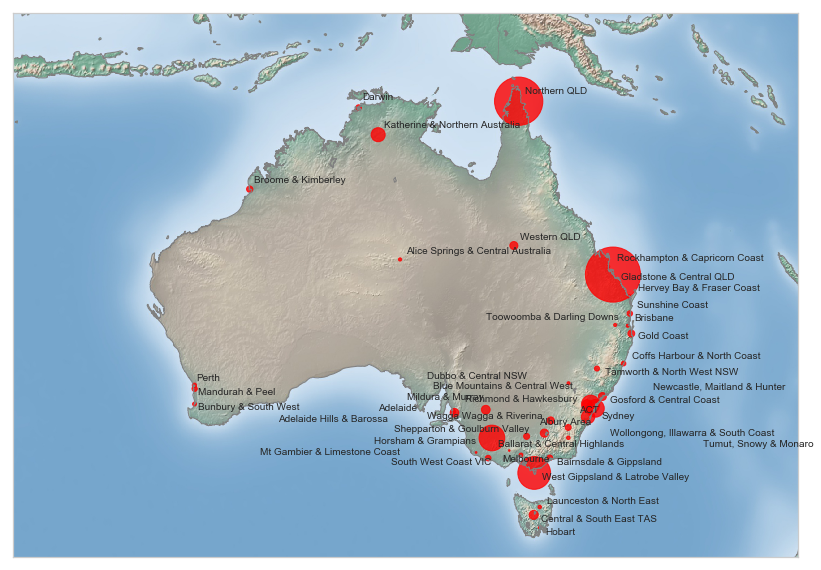

In [9]:
df_locations = df_locations[df_locations['Latitude'] < 0]
fig = plt.figure(figsize=(20, 10))
aus_map = Basemap(projection='lcc', resolution='i', lat_0=-25.6, lon_0=134.35, width=6.5E6, height=4.5E6)
aus_map.shadedrelief()
aus_map.drawcoastlines(color='gray')
aus_map.drawcountries(color='gray')

x, y = aus_map(df_locations['Longitude'].values,df_locations['Latitude'].values)

plt.scatter(x,y,s=df_locations['Count']/20,marker='o',c='red',alpha=0.8)

text = [plt.text(x[i] * (1 + 0.01), y[i] * (1 + 0.01) , df_locations['Location'].values[i], fontsize=10) for i in range(len(x))]
adjust_text(text)

plt.show()